In [1]:
#Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# Import some new modules for computing linear regressions
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
from collections import Counter

In [2]:
#Enable inline plots
%matplotlib inline
#Set default figure sizes
rcParams['figure.figsize'] = 20,6
#Set the seaborn style and font scale
sns.set_style('whitegrid')
sns.set(font_scale=2)

In [3]:
#Import the streamflow data CSV and format columns
df=pd.read_csv('GageData.csv',dtype={'site_no':'str'},parse_dates=['datetime'])

In [4]:
#Add year, month, and water_year columns
df['year'] = df['datetime'].map(lambda x: x.year)
df['month'] = df['datetime'].map(lambda x: x.month)
df['water_year'] = df['datetime'].apply(lambda x: x.year if x.month >= 10 else x.year - 1)

In [5]:
#Compute flow in cms
df['MeanFlow_cms'] = df['MeanFlow_cfs'] * 0.028316847 

In [6]:
#Set the index to full date
df.index = df.datetime

### Compute total monthly stream flow
Group by month and year, computing total discharge for all days in each month.

In [7]:
#Group data on year and month
groupObj = df.groupby(('year','month'))
sMonthlyFlow = groupObj['MeanFlow_cms'].sum()
#Convert series to dataframe
dfMonthlyFlow = sMonthlyFlow.to_frame()
dfMonthlyFlow.head()

MeanFlow_cms
year month              
1930 10       161.802464
     11       246.498153
     12       638.941336
1931 1        801.989741
     2        377.973274

### Compute the 7-month rolling average of monthly stream flow

In [8]:
#Compute 7 month rolling average
dfMonthlyFlow['7Q'] = dfMonthlyFlow.rolling(window=7,min_periods=7).mean()
dfMonthlyFlow.head(10)

MeanFlow_cms          7Q
year month                          
1930 10       161.802464         NaN
     11       246.498153         NaN
     12       638.941336         NaN
1931 1        801.989741         NaN
     2        377.973274         NaN
     3        628.888855         NaN
     4       1587.867196  634.851574
     5       1612.984239  842.163256
     6        457.373713  872.288336
     7        871.196115  905.467590

### Compute min of 7Q for each year

In [9]:
dfLowFlow = dfMonthlyFlow.groupby('year')['7Q'].min().to_frame()
#Drop null records
dfLowFlow.dropna(inplace=True)

dfLowFlow.head()

,7Q
year,
1931,634.851574
1932,401.399397
1933,184.913056
1934,163.958589
1935,505.241320


### Compute return interval (RI) and probability of recurrence (POR)

In [10]:
### Compute rankings
dfLowFlow['rank'] = dfLowFlow.rank(ascending=True)
dfLowFlow.sort_values(by='7Q',ascending=True,inplace=True)

In [11]:
# Compute Return Interval (RI)
countRecs = dfLowFlow['rank'].max()
dfLowFlow['RI'] = (countRecs + 1) / dfLowFlow['rank']

In [12]:
# Compute probability of recurrence (POR)
dfLowFlow['POR'] = 1 / dfLowFlow['RI'] 

In [13]:
dfLowFlow.head()

,7Q,rank,RI,POR
year,,,,
1934,163.958589,1.0,88.000000,0.011364
1981,173.772400,2.0,44.000000,0.022727
1933,184.913056,3.0,29.333333,0.034091
1942,226.385101,4.0,22.000000,0.045455
1980,226.708722,5.0,17.600000,0.056818


### Compute the [exponential] regression using NumPy functions

In [14]:
#Set the X and Y variables
x = dfLowFlow['POR']
y = dfLowFlow['7Q']

In [15]:
# Compute the slope and intercept using the polyfit function
# -> Use the *log of POR* to mimic an exponential relation
#    http://bit.ly/2FOLJk2
regSlope, ln_regIntercept = np.polyfit(x, np.log(y), 1)

# Compute the true intercept from the ln_intercept
regIntercept = np.exp(ln_regIntercept)

# Create a printer friendly equation
regText = "y = {0:.2f} * e^({1:.2f}x)".format(regIntercept,regSlope)
print(regText)

y = 205.67 * e^(1.54x)


#### Apply the regression to compute 7Q10 (min flow at a 10% POR)

In [16]:
q10 = regIntercept * np.exp(regSlope * 0.10)
print(q10)

239.893608093


#### Construct a trendline dataset using the exponential formula
Seaborn/Matplotlib's trendline represents a linear function, so to add a trendline for another relationship (e.g. exponential) we need to construct it ourselves. We do this by generating an array of equally spaced X values (using NumPy's `linspace` function), and then compute the corresponding Y values by applying the function derived above. 

In [17]:
#Compute the array of 100 X value spanning from the min and max POR values
arrX = np.linspace(x.min(),x.max(),100)

#Compute the corresponding Y's
arrY = regIntercept * np.exp(regSlope*arrX)

### Plot...

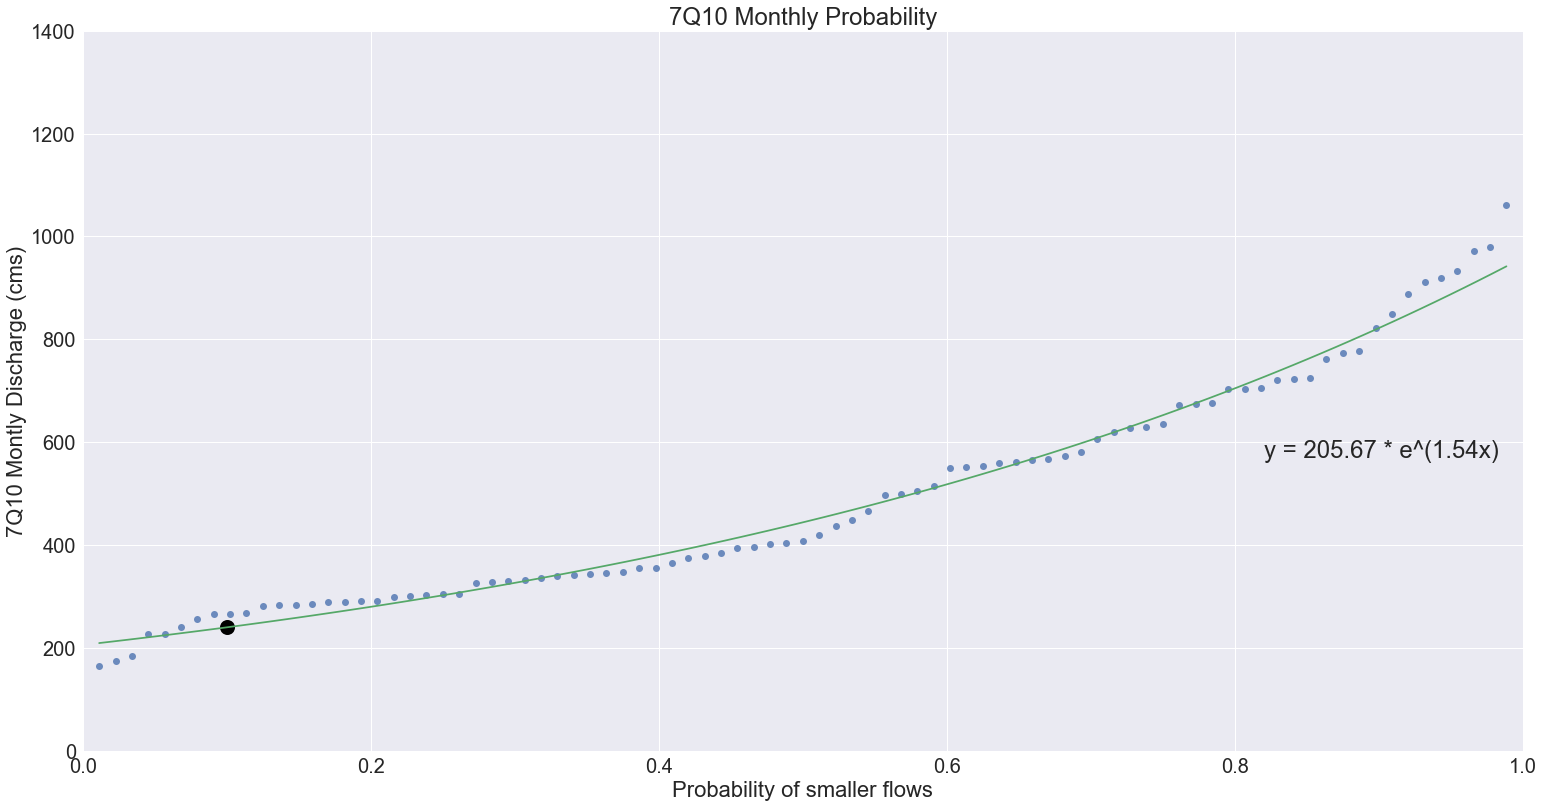

In [18]:
#Create the blank figure
fig = plt.figure(figsize=(20,10))

#Add axes to the figure
ax = fig.add_axes([.1, .1, 1, 1])

#--Generate plot
#Plot the data
ax = sns.regplot(x='POR',
                 y='7Q',
                 data=dfLowFlow,
                 logx=False,
                 fit_reg=False,
                 ci=None)


#--Specify plot and layout parameters

#Set bounds of plot
ax.set_xlim(0,1)
ax.set_ylim(0,1400)

#Set title and axis labels
ax.set_title('7Q10 Monthly Probability')
ax.set_xlabel('Probability of smaller flows')
ax.set_ylabel('7Q10 Montly Discharge (cms)')

#Add an annotation of the formula
ax.text(0.82,570, regText)

#---Add 7Q10 and the trendline
#Add the 7Q10 (computed earler as 'q10') as a large black circle
ax = plt.plot(0.10,q10,'ok',markersize=15)

#Add the trendline data
ax = plt.plot(arrX,arrY)


### How many months had flows under 7Q10?
Here we filter our table of Monthly total discharge to identify records where discharge fell below the 7Q10 threshold.

In [19]:
#We need to 'flatten' our multi-level index into one object
dfFlow = dfMonthlyFlow.reset_index()

#### Count low flows per year

In [20]:
#Create a view of the records where MeanFlow fell below the computed q10
dfLowFlowRecs = dfFlow[dfFlow['MeanFlow_cms'] < q10]
print("{} months fell below 7Q10".format(len(dfLowFlowRecs)))

111 months fell below 7Q10


#### Plot the flows, indicicating which months fell below 7Q10

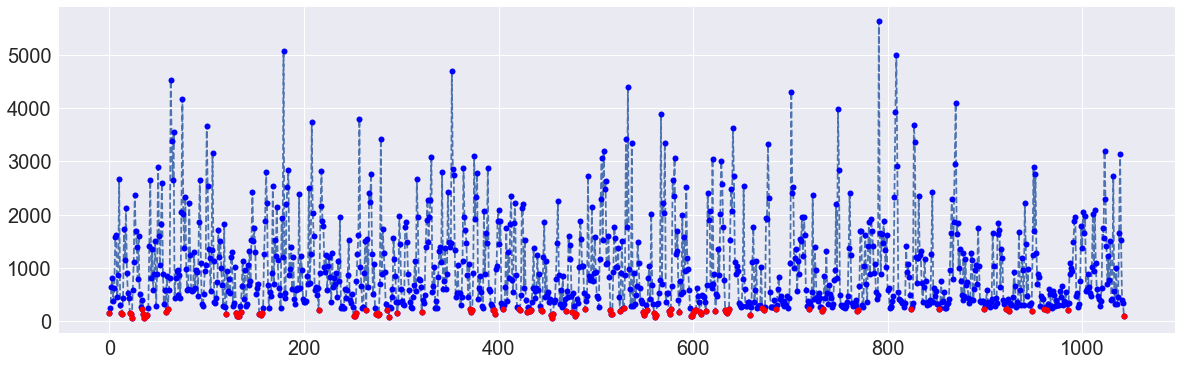

In [21]:
#First, plot all lines
plt.plot(dfFlow['MeanFlow_cms'],'--')
#Plot all points
plt.plot(dfFlow['MeanFlow_cms'],'bo',markersize=6)
#Plot all low flow points
plt.plot(dfLowFlowRecs['MeanFlow_cms'],'ro',markersize=6);